# Generalized advantage estimation

In the previous section, we discussed two methods for estimating the advantage function:

$$
\begin{align*}
    A(\mathbf{s}_t, \mathbf{a}_t) &\approx \sum_{t'\geq t} \gamma^{t'}r(\mathbf{s}_{t'}, \mathbf{a}_{t'}) - V(\mathbf{s}_t)\\
    A(\mathbf{s}_t, \mathbf{a}_t) &\approx r(\mathbf{s}_t, \mathbf{a}_t) + \gamma V(\mathbf{s}_{t+1}) - V(\mathbf{s}_t)
\end{align*}
$$

In the actor-critic algorithm, we often choose the latter estimator because it typically provides a lower variance estimate. This is because the variance of a sum grows linearly with the number of terms. However, it is important to note that there is a bias-variance tradeoff between the two estimates: the first estimator is unbiased but has high variance, while the second is biased but has lower variance. Is it possible to find an estimator that effectively balances the trade-off between bias and variance? In 2016, Schulman et al. introduced the Generalized Advantage Estimator (GAE), which is designed to achieve this balance through combining the above two estimators [1]. <br>

Instead of using a one-step look forward estimate, the authors proposed using a $k$ step look forward estimate:

$$A^{(k)}(\mathbf{s}_t, \mathbf{a}_t) = r(\mathbf{s}_t, \mathbf{a}_t) + \gamma r(\mathbf{s}_{t+1}, \mathbf{a}_{t+1})+\gamma^2r(\mathbf{s}_{t+2}, \mathbf{a}_{t+2})+...+\gamma^{k-1}r(\mathbf{s}_{t+k-1}, \mathbf{a}_{t+k-1})+\gamma^k V(\mathbf{s}_t)$$

This estimator combines the strengths of both previous estimators, offering an improved bias-variance tradeoff. However, it is not clear which values of $k$ should one choose. The author suggests using an exponential weighted average of all estimators, namely

$$A^{GAE(\lambda)}(\mathbf{s}_t, \mathbf{a}_t) = (1-\lambda) (A^{(1)}(\mathbf{s}_t, \mathbf{a}_t)+\lambda A^{(2)}(\mathbf{s}_t, \mathbf{a}_t) +\lambda^2 A^{(3)}(\mathbf{s}_t, \mathbf{a}_t)+...)$$

Where the scalar $(1-\lambda)$ serves as a normalizing factor. We call the above estimator the generalized advantage estimator (GAE) with parameter $\lambda$. We can simplify the expression by letting $\delta_t=r_t + \gamma V(\mathbf{s}_{t+1}) - V(\mathbf{s}_t)$ denote the temporal difference residual at time $t$. Using this notation, we can reexpress $A^{(k)}$ as

$$
\begin{align*}
A^{(k)} &= r_t + \gamma r_{t+1}+\gamma^2r_{t+2}+...+\gamma^{k-1}r_{t+k-1}+\gamma^k V(\mathbf{s}_t) \\
&= \delta_t + \gamma\delta_{t+1} + \gamma^2\delta_{t+2}+...\gamma^{k-1}\delta_{t+k-1}
\end{align*}
$$

Substituting this expression, we have 

$$
\begin{align*}
A^{GAE(\lambda)} &= (1-\lambda) (A^{(1)}+\lambda A^{(2)}+\lambda^2 A^{(3)}+...)\\
&= (1-\lambda) [\delta_t + \lambda(\delta_t+\gamma\delta_{t+1}) +\lambda^2(\delta_t+\gamma\delta_{t+1}+\gamma^2\delta_{t+2})+...]\\
&= (1-\lambda) [\delta_t (1+\lambda+\lambda^2+...)+\gamma\delta_{t+1}(\lambda+\lambda^2+\lambda^3...)+...]\\
&= \sum_{i=0}^\infty (\lambda \gamma)^i\delta_{t+i}
\end{align*}
$$

From the above equation, we see that when $\lambda =1$, we get the first estimator, wheras when $\lambda=0$, we recover the one-step estimator. This means that $\lambda\in (0,1)$ controls the bias variance tradeoff of the estimator. By tuning $\lambda$, we can design an advantage estimator that trades variance in expense of introducing some bias.<br>

Implementation-wise, the GAE estimator is also easy to compute. Note that it satisfies the recurrence. 

$$A_t^{GAE(\lambda)} = \delta_t + (\lambda\gamma) A_{t+1}^{GAE(\lambda)}$$

This means that we can compute the estimator efficiently by recursively applying this formula, starting from the end of an episode and working backwards to the beginning. Below we implement the actor critic algorithm using the generalized advantage estimator. 

## Generalized advantage estimator implementation

In [ ]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ActorCriticGAEAgent(Agent):
    """
    Implementation of Actor Critic agent with generalized advantage estimation
    """
    def __init__(self, env, policy, value, lr=1e-4, device="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.value = value.to(device)
        self.device = device
        self.policy_optimizer = optim.Adam(self.policy.parameters() , lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.policy_scheduler = optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=1000, gamma=0.5)
        self.value_scheduler = optim.lr_scheduler.StepLR(self.value_optimizer, step_size=1000, gamma=0.5)

    def learn_episode(self, *param):
        batch_size, max_steps, gamma, lamb, normalize = param
        value_loss, policy_loss, reward = 0.0, 0.0, 0.0
        for _ in range(batch_size):
            states, actions, rewards, dones = self.sample_trajectory(env=self.env, gamma=gamma, max_steps=max_steps)
            with torch.no_grad():
                target = rewards + gamma * (1 - dones) * self.value(states[1:])
            value_loss += nn.MSELoss()(self.value(states[:-1]), target) / batch_size
            log_probs = self.policy.log_prob(states[:-1], actions)
            advantage = self.estimate_advantage(rewards, self.value(states[:-1]), gamma, lamb, normalize)
            policy_loss += (-log_probs * advantage.detach()).sum() / batch_size
            reward += rewards.sum().item() / batch_size
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        loss = policy_loss.item() + value_loss.item()
        return loss, reward

    def estimate_advantage(self, rewards, values, gamma, lamb, normalize=False):
        with torch.no_grad():
            advantages = []
            advantage = 0
            next_value = 0
            for reward, value in zip(reversed(rewards), reversed(values)):
                delta = reward + gamma * next_value - value
                advantage = delta + gamma * lamb * advantage
                advantages.insert(0, advantage)
                next_value = value
            advantages = torch.tensor(advantages).float().to(self.device)
            if normalize:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages

We tested the performance of the Generalized Advantage Estimator for different values of $\lambda$, as shown below. From the graph, it appears that the agent with $\lambda=1$ learns the fastest. However, the reward trajectory after epoch $1000$ still exhibits significant variation, which is expected since $\lambda=1$ provides an unbiased but high-variance estimator. On the other hand, the agent with $\lambda=0.8$, although it learns slightly slower, demonstrates much more stability in the long run. This suggests that it is possible to trade some bias for reduced variance.

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(4, 2)
value = ValueNetwork(4, 128)
agent = ActorCriticGAEAgent(env, policy, value, lr=1e-3)
history = agent.learn(3500, batch_size=1, lambda_=0.00, print_every=100, normalize=True)

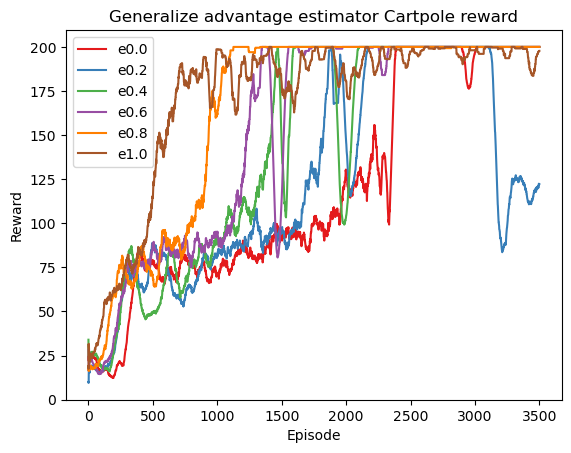

In [7]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_gae/l000_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_gae/l020_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_gae/l040_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_gae/l060_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_gae/l080_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/ac_gae/l100_reward.npy"),]

names = ["e0.0", "e0.2", "e0.4", "e0.6", "e0.8", "e1.0"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(smooth(reward, 50), c=colors[i], label=names[i])
plt.title("Generalize advantage estimator Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://arxiv.org/pdf/1506.02438